In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


Mon Feb 22 03:47:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
# training set

# 91-image + General-100
# train with 91 first
# after saturation
# fine-tune with both dataset

# scaling 0.9 0.8 0.7 0.6 0.2
# roatation 90 180 270
# sub-images 7^2 / 19^2 (for n = 3)

In [ ]:
# test set

# Set5 + Set14

In [ ]:
# learning rate 1e-3
# learning rate 1e-4 for deConv layer

# all learning rate 1/2 for fine-tuneing step

In [ ]:
# d = 56
# s = 12
# m = 4

# Conv(56 12 4)
# Conv(5, 56, 1)
# Conv(1, 12, 56)

# 4 X Conv(3, 12 , 12)

# Conv(1, 56, 12)
# DeConv(9, 1, 56)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# training set

# 91-image + General-100
# train with 91 first
# after saturation
# fine-tune with both dataset

# scaling 0.9 0.8 0.7 0.6 0.2
# roatation 90 180 270
# sub-images 7^2 / 19^2 (for n = 3)
from google.colab import output

DATA_ZIP_PATH = '/content/gdrive/My Drive/Colab Notebooks/data/SR/'

# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/gdrive/My Drive/Colab Notebooks/data/SR/General-100_training3.zip" "General-100.zip"
!cp "/content/gdrive/My Drive/Colab Notebooks/data/SR/T91_training3.zip" "T91.zip"
!cp "/content/gdrive/My Drive/Colab Notebooks/data/SR/Set5.zip" "Set5.zip"
!cp "/content/gdrive/My Drive/Colab Notebooks/data/SR/Set14.zip" "Set14.zip"

!mkdir "./General-100_training"
!mkdir "./T91_training"

!unzip "General-100.zip" -d "./General-100_training/"
!unzip "T91.zip" -d "./T91_training/"
!unzip "Set5.zip"
!unzip "Set14.zip"

output.clear()

In [ ]:
import os

In [ ]:
g100_images = os.listdir("General-100_training")
g100_size = len(g100_images)

In [ ]:
t91_images = os.listdir("T91_training")
t91_size = len(t91_images)

In [ ]:
set14_images = os.listdir("Set14/original")
set14_size = len(set14_images)

In [ ]:
set5_images = os.listdir("Set5/original")
set5_size = len(set5_images)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import PIL
from PIL import Image

import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

In [ ]:
# test set

# Set5 + Set14

In [ ]:
# d = 56
# s = 12
# m = 4

# Conv(56 12 4) 
# Conv(5, 56, 1) : feature extraction
# Conv(1, 12, 56) : shrinking

# 4 X Conv(3, 12 , 12) : mapping_#

# Conv(1, 56, 12) : expanding
# DeConv(9, 1, 56):deconvolution

class FSRCNN(nn.Module):
    def __init__(self):
        super(FSRCNN, self).__init__()

        self.convolution = nn.Sequential(OrderedDict([
                                                     ('feature_extraction', nn.Conv2d(1, 56, kernel_size=5, stride=1, padding=2)),
                                                     ('feature_extraction_prelu', nn.PReLU()),
                                                     ('shrinking', nn.Conv2d(56, 12, kernel_size=1, stride=1, padding=0)),
                                                     ('shrinking_prelu', nn.PReLU()),
                                                     ('mapping_1', nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)),
                                                     ('mapping_1_prelu', nn.PReLU()),
                                                     ('mapping_2', nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)),
                                                     ('mapping_2_prelu', nn.PReLU()),
                                                     ('mapping_3', nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)),
                                                     ('mapping_3_prelu', nn.PReLU()),
                                                     ('mapping_4', nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)),
                                                     ('mapping_4_prelu', nn.PReLU()),
                                                     ('expanding', nn.Conv2d(12, 56, kernel_size=1, stride=1, padding=0)),
                                                     ('expanding_prelu', nn.PReLU())                                  
        ]))

        self.deconvolution = nn.ConvTranspose2d(56, 1, kernel_size=9, stride=3, padding=3)

    def _init_weight(self):
         nn.init.kaiming_normal_(self.convolution.feature_extraction.weight.data)
         nn.init.kaiming_normal_(self.convolution.shrinking.weight.data)
         nn.init.kaiming_normal_(self.convolution.mapping_1.weight.data)
         nn.init.kaiming_normal_(self.convolution.mapping_2.weight.data)
         nn.init.kaiming_normal_(self.convolution.mapping_3.weight.data)
         nn.init.kaiming_normal_(self.convolution.mapping_4.weight.data)
         nn.init.kaiming_normal_(self.convolution.expanding.weight.data)
         nn.init.kaiming_normal_(self.deconvolution.weight.data)

    def forward(self, x):
        x = self.convolution(x)

        x = self.deconvolution(x)

        return x

In [ ]:
fsrcnn = FSRCNN()
fsrcnn._init_weight()

In [ ]:
fsrcnn.to(device)

FSRCNN(
  (convolution): Sequential(
    (feature_extraction): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (feature_extraction_prelu): PReLU(num_parameters=1)
    (shrinking): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (shrinking_prelu): PReLU(num_parameters=1)
    (mapping_1): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (mapping_1_prelu): PReLU(num_parameters=1)
    (mapping_2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (mapping_2_prelu): PReLU(num_parameters=1)
    (mapping_3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (mapping_3_prelu): PReLU(num_parameters=1)
    (mapping_4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (mapping_4_prelu): PReLU(num_parameters=1)
    (expanding): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (expanding_prelu): PReLU(num_parameters=1)
  )
  (deconvolution): ConvTranspose2d(56, 1, kernel_size=(9, 9), st

In [ ]:
class T91_Dataset(Dataset):
    def __init__(self,
                 image_path,
                 images):
        
        self.image_path = image_path
        self.images = images
        self.transforms = transforms.ToTensor()
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        HR_image = Image.open(
            os.path.join(self.image_path, self.images[index])
        ).convert("YCbCr")

        HR_image, _, _ = HR_image.split()
        
        LR_image = HR_image.resize((16,16))

        LR_image = self.transforms(LR_image)
        HR_image = self.transforms(HR_image)

        return LR_image, HR_image

In [ ]:
['d'+char for char in ['a','b','c']]

['da', 'db', 'dc']

In [ ]:
class General_Dataset(Dataset): # T91 + General-100
    def __init__(self,
                 image_path1,
                 image_path2,
                 images1,
                 images2):
        
        self.images = [image_path1+'/'+image for image in images1] + [image_path2+'/'+image for image in images2]
        self.images_len = len(self.images)
        self.transforms = transforms.ToTensor()
    
    def __len__(self):
        return self.images_len

    def __getitem__(self, index):
        HR_image = Image.open(
            os.path.join(self.images[index])
        ).convert("YCbCr")

        HR_image, _, _ = HR_image.split()

        LR_image = HR_image.resize((16,16))

        LR_image = self.transforms(LR_image)
        HR_image = self.transforms(HR_image)

        return LR_image, HR_image

In [ ]:
class Set14_Dataset(Dataset):
    def __init__(self,
                 image_path,
                 images):
        
        self.image_path = image_path
        self.images = images
        self.transforms = transforms.ToTensor()
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        HR_image = Image.open(
            os.path.join(self.image_path,'original', self.images[index])
        ).convert("YCbCr")
        HR_image, _, _ = HR_image.split()
        LR_image = Image.open(
            os.path.join(self.image_path,'LRbicx3', self.images[index])
        ).convert("YCbCr")
        LR_image, _, _ = LR_image.split()

        LR_image = self.transforms(LR_image)
        HR_image = self.transforms(HR_image)

        return LR_image, HR_image

In [ ]:
t91_dataset = T91_Dataset("T91_training", t91_images)
general_dataset = General_Dataset("T91_training", "General-100_training", t91_images, g100_images)
set14_dataset = Set14_Dataset("Set14", set14_images)

In [ ]:
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

indices = list(range(t91_dataset.__len__()))
split = int(np.floor(0.2 * t91_dataset.__len__()))
np.random.seed(2021)
np.random.shuffle(indices)
train_indices , valid_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(t91_dataset, batch_size=128, sampler=train_sampler)
valid_loader = DataLoader(t91_dataset, batch_size=128, sampler=valid_sampler)

In [ ]:
# learning rate 1e-3
# learning rate 1e-4 for deConv layer

# all learning rate 1/2 for fine-tuneing step

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW([{'params':fsrcnn.convolution.parameters()},
                               {'params':fsrcnn.deconvolution.parameters(),'lr':1e-4}], lr=1e-3)

epochs=20

In [ ]:
for epoch in range(epochs):    
    
    fsrcnn.train()
    length = len(train_loader)
    running_loss = 0.0

    for i, (lr_image, hr_image) in enumerate(train_loader):
        lr_image = lr_image.to(device)
        hr_image = hr_image.to(device)

        optimizer.zero_grad()

        upsample = fsrcnn(lr_image)
        loss = loss_fn(upsample, hr_image)

        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_loss is {running_loss/(i+1):.4f}')

    print(f'epoch {epoch} : train loss {running_loss/length:.4f}')

    fsrcnn.eval()
    length = len(valid_loader)
    running_acc = 0.0

    for i, (lr_image, hr_image) in enumerate(valid_loader):
        lr_image = lr_image.to(device)
        hr_image = hr_image.to(device)

        upsample = fsrcnn(lr_image)
        loss = loss_fn(upsample, hr_image)

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_acc is {running_acc/(i+1):.4f}')
    print(f'epoch {epoch} : val loss {running_loss/length:.4f}')

after looking at 128 images, running_loss is 0.0381
after looking at 6528 images, running_loss is 0.0335
after looking at 12928 images, running_loss is 0.0302
epoch 0 : train loss 0.0275
after looking at 128 images, running_acc is 0.0000
epoch 0 : val loss 0.1087
after looking at 128 images, running_loss is 0.0178
after looking at 6528 images, running_loss is 0.0185
after looking at 12928 images, running_loss is 0.0175
epoch 1 : train loss 0.0166
after looking at 128 images, running_acc is 0.0000
epoch 1 : val loss 0.0653
after looking at 128 images, running_loss is 0.0142
after looking at 6528 images, running_loss is 0.0131
after looking at 12928 images, running_loss is 0.0126
epoch 2 : train loss 0.0121
after looking at 128 images, running_acc is 0.0000
epoch 2 : val loss 0.0477
after looking at 128 images, running_loss is 0.0103
after looking at 6528 images, running_loss is 0.0105
after looking at 12928 images, running_loss is 0.0100
epoch 3 : train loss 0.0097
after looking at 128 

In [ ]:
# fine tune with bigger dataset\

#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

indices = list(range(general_dataset.__len__()))
split = int(np.floor(0.2 * general91_dataset.__len__()))
np.random.seed(2021)
np.random.shuffle(indices)
train_indices , valid_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(general_dataset, batch_size=128, sampler=train_sampler)
valid_loader = DataLoader(general_dataset, batch_size=128, sampler=valid_sampler)

NameError: ignored

In [ ]:
# learning rate 1e-3/2
# learning rate 1e-4/2 for deConv layer

# all learning rate 1/2 for fine-tuneing step

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW([{'params':fsrcnn.convolution.parameters()},
                               {'params':fsrcnn.deconvolution.parameters(),'lr':5e-5}], lr=5e-4)

epochs=20

In [ ]:
for epoch in range(epochs):    
    
    fsrcnn.train()
    length = len(train_loader)
    running_loss = 0.0

    for i, (lr_image, hr_image) in enumerate(train_loader):
        lr_image = lr_image.to(device)
        hr_image = hr_image.to(device)

        optimizer.zero_grad()

        upsample = fsrcnn(lr_image)
        loss = loss_fn(upsample, hr_image)

        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_loss is {running_loss/(i+1):.4f}')

    print(f'epoch {epoch} : train loss {running_loss/length:.4f}')

    fsrcnn.eval()
    length = len(valid_loader)
    running_acc = 0.0

    for i, (lr_image, hr_image) in enumerate(valid_loader):
        lr_image = lr_image.to(device)
        hr_image = hr_image.to(device)

        upsample = fsrcnn(lr_image)
        loss = loss_fn(upsample, hr_image)

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_acc is {running_acc/(i+1):.4f}')
    print(f'epoch {epoch} : val loss {running_loss/length:.4f}')

after looking at 128 images, running_loss is 0.0018
after looking at 6528 images, running_loss is 0.0038
after looking at 12928 images, running_loss is 0.0030
after looking at 19328 images, running_loss is 0.0027
after looking at 25728 images, running_loss is 0.0026
after looking at 32128 images, running_loss is 0.0025
after looking at 38528 images, running_loss is 0.0025
after looking at 44928 images, running_loss is 0.0024
after looking at 51328 images, running_loss is 0.0024
after looking at 57728 images, running_loss is 0.0024
after looking at 64128 images, running_loss is 0.0023
after looking at 70528 images, running_loss is 0.0023
after looking at 76928 images, running_loss is 0.0023
after looking at 83328 images, running_loss is 0.0023
after looking at 89728 images, running_loss is 0.0023
after looking at 96128 images, running_loss is 0.0023
after looking at 102528 images, running_loss is 0.0023
after looking at 108928 images, running_loss is 0.0023
epoch 0 : train loss 0.0023
a

In [ ]:
set14_loader = DataLoader(set14_dataset, batch_size=1, shuffle=False)

In [ ]:
#https://github.com/yjn870/FSRCNN-pytorch/blob/master/

def preprocess(img, device):
    img = np.array(img).astype(np.float32)
    ycbcr = convert_rgb_to_ycbcr(img)
    x = ycbcr[..., 0]
    x /= 255.
    x = torch.from_numpy(x).to(device)
    x = x.unsqueeze(0).unsqueeze(0)
    return x, ycbcr
def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))
    
#https://stackoverflow.com/questions/34913005/color-space-mapping-ycbcr-to-rgb
def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [ ]:
fsrcnn.eval()

lr_image = Image.open(
    os.path.join('./Set14','LRbicx3', 'barbara.png')
    ).convert("YCbCr")
hr_image = Image.open(
    os.path.join('./Set14','original', 'barbara.png')
    ).convert("YCbCr")
bicubic = lr_image.resize((720, 576), resample=PIL.Image.BICUBIC)
lr_image, _, _ = lr_image.split()
hr_image, _, _ = hr_image.split()

transform = transforms.ToTensor()

lr_image = transform(lr_image)
hr_image = transform(hr_image)

lr_image = lr_image.to(device)
hr_image = hr_image.to(device)

upsample = fsrcnn(lr_image.unsqueeze(0))
loss_fn = torch.nn.MSELoss()
mse = loss_fn(upsample, hr_image)
psnr = calc_psnr(upsample, hr_image)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 576, 720])) that is different to the input size (torch.Size([1, 1, 576, 720])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([3, 576, 720])
mse:0.0028235672507435083
psnr:25.492019653320312


<Figure size 432x288 with 0 Axes>

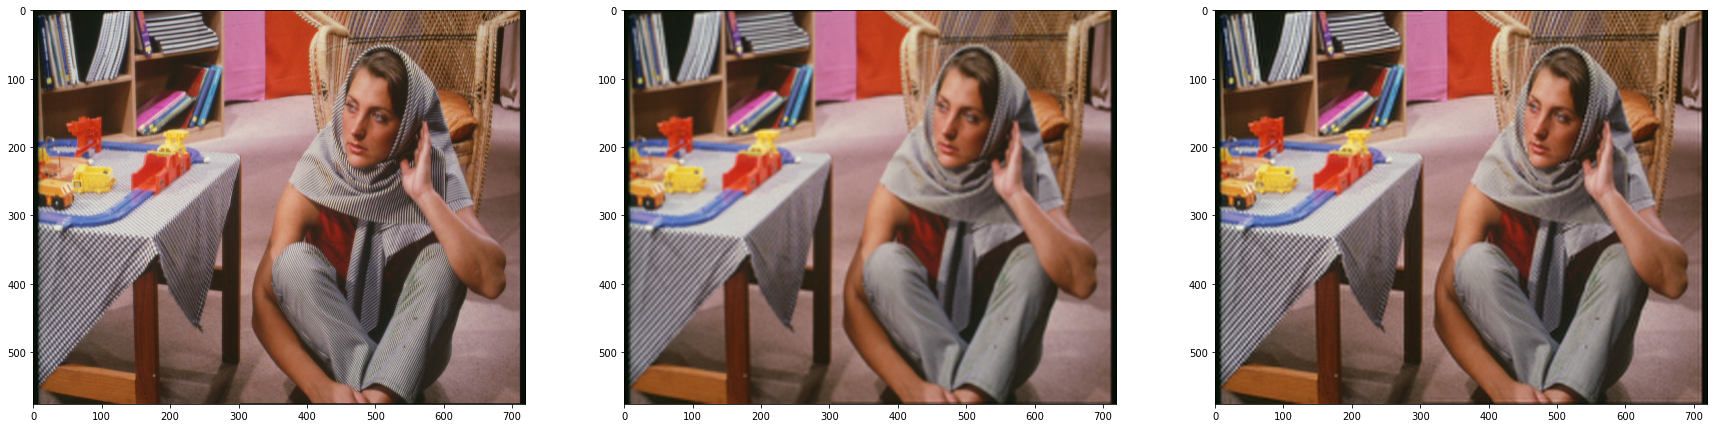

In [ ]:
plt.figure()

f, axarr = plt.subplots(1,3)
f.set_figheight(30)
f.set_figwidth(30)

hr_image = Image.open(
    os.path.join('./Set14','original', 'barbara.png')
    ).convert("RGB")

bicubic = transform(bicubic).to(device)
upsample = torch.cat((upsample.squeeze(0), bicubic[1,:, :].unsqueeze(0), bicubic[2,:,:].unsqueeze(0)),0)
print(upsample.shape)
bicubic = bicubic.cpu().numpy() 
upsample = upsample.detach().cpu().numpy() 

axarr[0].imshow(hr_image)
axarr[1].imshow(ycbcr2rgb(255*bicubic.transpose(1,2,0)))
axarr[2].imshow(ycbcr2rgb(255*upsample.transpose(1,2,0)))

print(f"mse:{mse}")
print(f"psnr:{psnr}")

torch.Size([3, 276, 276])
mse:0.0006010569049976766
psnr:32.210845947265625


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 276, 276])) that is different to the input size (torch.Size([1, 1, 276, 276])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<Figure size 432x288 with 0 Axes>

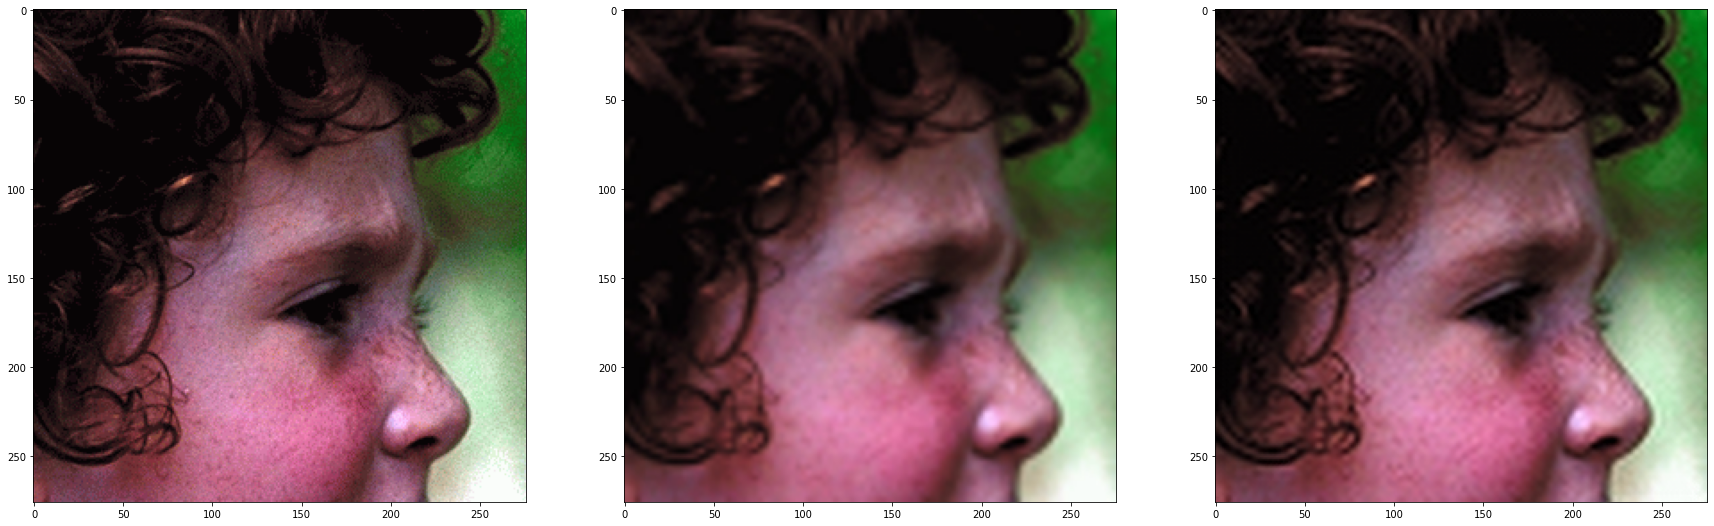

In [ ]:
fsrcnn.eval()

lr_image = Image.open(
    os.path.join('./Set14','LRbicx3', 'face.png')
    ).convert("YCbCr")
hr_image = Image.open(
    os.path.join('./Set14','original', 'face.png')
    ).convert("YCbCr")
bicubic = lr_image.resize((276, 276), resample=PIL.Image.BICUBIC)
lr_image, _, _ = lr_image.split()
hr_image, _, _ = hr_image.split()

transform = transforms.ToTensor()

lr_image = transform(lr_image)
hr_image = transform(hr_image)

lr_image = lr_image.to(device)
hr_image = hr_image.to(device)

upsample = fsrcnn(lr_image.unsqueeze(0))
loss_fn = torch.nn.MSELoss()
mse = loss_fn(upsample, hr_image)
psnr = calc_psnr(upsample, hr_image)
plt.figure()

f, axarr = plt.subplots(1,3)
f.set_figheight(30)
f.set_figwidth(30)

hr_image = Image.open(
    os.path.join('./Set14','original', 'face.png')
    ).convert("RGB")

bicubic = transform(bicubic).to(device)
upsample = torch.cat((upsample.squeeze(0), bicubic[1,:, :].unsqueeze(0), bicubic[2,:,:].unsqueeze(0)),0)
print(upsample.shape)
bicubic = bicubic.cpu().numpy() 
upsample = upsample.detach().cpu().numpy() 

axarr[0].imshow(hr_image)
axarr[1].imshow(ycbcr2rgb(255*bicubic.transpose(1,2,0)))
axarr[2].imshow(ycbcr2rgb(255*upsample.transpose(1,2,0)))

print(f"mse:{mse}")
print(f"psnr:{psnr}")

In [ ]:
for image in set5_images:
    lr_image = Image.open(
        os.path.join('./Set5','LRbicx3', image)
        ).convert("YCbCr")
    hr_image = Image.open(
        os.path.join('./Set5','original', image)
        ).convert("YCbCr")

    print(image)
    print(lr_image.size)
    print(hr_image.size)

bird.png
(96, 96)
(288, 288)
head.png
(92, 92)
(280, 280)
butterfly.png
(84, 84)
(256, 256)
woman.png
(76, 112)
(228, 344)
baby.png
(168, 168)
(512, 512)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 288, 288])) that is different to the input size (torch.Size([1, 1, 288, 288])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([3, 288, 288])
mse:0.0005586996558122337
psnr:32.52821731567383


<Figure size 432x288 with 0 Axes>

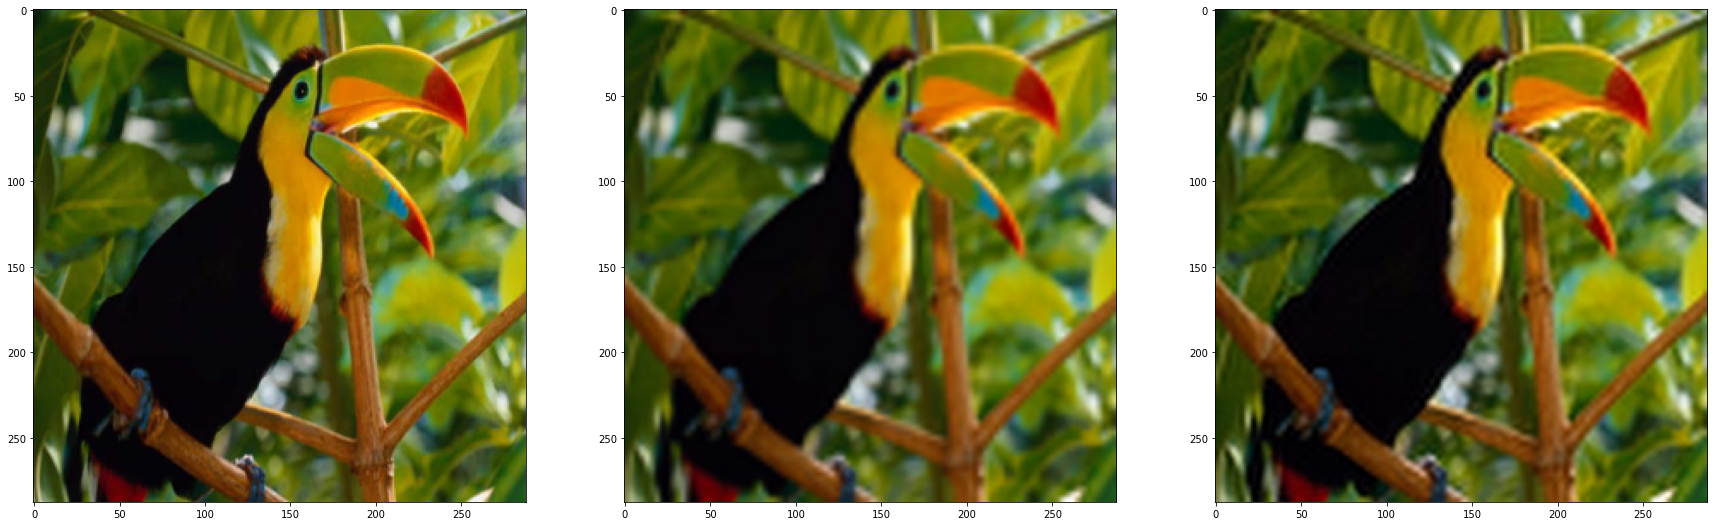

In [ ]:
fsrcnn.eval()

image='bird.png'

lr_image = Image.open(
    os.path.join('./Set5','LRbicx3', image)
    ).convert("YCbCr")
hr_image = Image.open(
    os.path.join('./Set5','original', image)
    ).convert("YCbCr")
bicubic = lr_image.resize((288, 288), resample=PIL.Image.BICUBIC)
lr_image, _, _ = lr_image.split()
hr_image, _, _ = hr_image.split()

transform = transforms.ToTensor()

lr_image = transform(lr_image)
hr_image = transform(hr_image)

lr_image = lr_image.to(device)
hr_image = hr_image.to(device)

upsample = fsrcnn(lr_image.unsqueeze(0))
loss_fn = torch.nn.MSELoss()
mse = loss_fn(upsample, hr_image)
psnr = calc_psnr(upsample, hr_image)
plt.figure()

f, axarr = plt.subplots(1,3)
f.set_figheight(30)
f.set_figwidth(30)

hr_image = Image.open(
    os.path.join('./Set5','original', image)
    ).convert("RGB")

bicubic = transform(bicubic).to(device)
upsample = torch.cat((upsample.squeeze(0), bicubic[1,:, :].unsqueeze(0), bicubic[2,:,:].unsqueeze(0)),0)
print(upsample.shape)
bicubic = bicubic.cpu().numpy() 
upsample = upsample.detach().cpu().numpy() 

axarr[0].imshow(hr_image)
axarr[1].imshow(ycbcr2rgb(255*bicubic.transpose(1,2,0)))
axarr[2].imshow(ycbcr2rgb(255*upsample.transpose(1,2,0)))

print(f"mse:{mse}")
print(f"psnr:{psnr}")

In [ ]:
hr_image.shape

torch.Size([1, 512, 512])